The dataset contains 1250 headlines from a variety of news publications. Each is given a rating between 0 and 100 for six emotion categories. 

Since ninety eight percent of the dataset has at least two emotions with non-zero ratings, it makes sense to treat this task as a multilabel classification probelm. The model should be able to make a prediction (present or not present) for each emotion label. 

In this notebook, I use the skmultilearn package's Chain Classifier with a Support Vector Classifier and a Recurrent Neural Network to make predictions and compare the results.

The best performing model for this task was ...


In [4]:
# basics
import pandas as pd
import numpy as np
import itertools

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [5]:
# use custom function to get the corpus df and labels 
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [6]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [7]:
# after processing, the text in the corpus df is all lower case, free of punctuation (except emotion-relevant exclamation points and question marks), 
# numbers, and special characters, and lemmatized
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [8]:
# The emotion df contains ratings for each emotion, the max rating, and label columns 
# for each emotion with a 1 indicating that the emotion is present (it has a non-zero 
# rating) or a 0 indicating that it is not.  
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

I've compiled my evaluation metrics in two functions. One is for evaluating how a model performed with respect to each individual emotion label. The other is a set of summary scores useful for comparing a model's overall performace with other models.

### Evaluating preformance on individual emotion labels

I use confusion matrices to display predicted labels vs. actual labels.

To compare performace on individual labels, I use accuracy, precision, recall, and f1 scores.

* Accuracy score tells us the ratio of correct predictions to total predictions 

* Precision score tells us the ratio of correct predictions to total predictions of the target class 

* Recall score tells us the ratio of correct predictions to the total true cases of the taget class

* F1 is a weighted average of precision and recall



In [9]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(10,15))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

To evaluate a model's performance on all labels, I compare jaccard similarity, hamming loss, and f1 macro scores.

* Jaccard Similarity is the ratio of correct labels to total predictions.

* Hamming Loss is the ratio of incorrect labels to total predictions. 

* F1 Macro is an mean of f1 scores (see above) for all labels.

Note that Jaccard Similarity and Hamming loss both count the correct or incorrect labels for each individual label and add them together. I use these metrics rather than ones requiring a perfect match across all labels because I'm interesting in knowing whether a model can predict subsets of the correct labels at a higher rate than others. In order to do so, I need metrics that do not treat a prediction that gets five out of six labels correct the same as one that gets zero out of six correct.


In [10]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

## TF-IDF

The data needs to be transformed into a numeric format before it can be used to train a model. 

One option is to use a [count vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). By this method, each document is represented by a count for each word that is present. 

As an example, I'll use the opening lines of Dickens's *Tale of Two Cities*: "It was the best of times, it was the worst of times" and "It was the age of wisdom, it was the age of foolishness."

Each row is a document and each column is a word in the corpus.

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|2   |2    |2    |1     |2   |2      |1      |0    |0       |0            |
|2   |2    |2    |0     |2   |0      |1      |2    |1       |1            |

Another option is to use term frequency - inverse document frequency (TF-IDF). TF-IDF is a representation of how import a word is in distinguishing a document from other documents in the corpus. The higher the score, the more distinguishing the word.

It's calculated by multiplying term frequency by inverse document frequency.

* Term Frequency
(times the word appears in the document/number of words in the document)

* Inverse Document Frequency
log(number of documents in the corpus/number documents in the corpus in which the word appears)

Here's how it looks on the whole document example:

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|0   |0    |0    |.06   |0   |.12    |.06    |0    |0       |0            |
|0   |0    |0    |0     |0   |0      |0      |.12  |.06     |.06          |

Using TF-IDF keeps models from treating words that aren't distinguishing to a document as significant in determining whether other documents should have the same label.


In [24]:
# first split the data into separate training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)

# use TfidVectorizer to get a sparse matrix of TF-IDF scores for each word in the corpus
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)


## One Versus Rest Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

*Insert pic*

For comparison, I tested methods that treats labels as independent and methods that allows for label correlations. In this notebook, I include:

* One Versus Rest Classifier

A One Versus Rest classifier trains a separate model for each label in the dataset. Each model's predictions are independent of the other models' predictions.

For this model, I used a logistic regression classifier.

* Correlated: Chain Classifier

A Chain Classifier trains a model for each label in the dataset, but each model's predictions are transferred to the next model, so the probabistic relationships between labels are taken into account.

For this model, I used a linear support vector classifier.

Chain Classifiers are sensitive to label order, so I tested all 750 possible label orders to find the best one. If my dataset were significantly larger or if I had significantly more label combinations to tested, it would have been too computationally expensive, and thus more practical to do a random selection of label orders to test. 

The Chain Classifier model did have a slight advantage over the One Versus Rest model. 


In [11]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [14]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4963768115942029
anger_label precision: 0.8154761904761905
anger_label recall 0.7873563218390804
anger_label f1 0.8011695906432749


disgust_label accuracy: 0.3372093023255814
disgust_label precision: 0.6590909090909091
disgust_label recall 0.6126760563380281
disgust_label f1 0.635036496350365


fear_label accuracy: 0.6402877697841727
fear_label precision: 0.8018018018018018
fear_label recall 0.8356807511737089
fear_label f1 0.8183908045977012


joy_label accuracy: 0.5437262357414449
joy_label precision: 0.7371134020618557
joy_label recall 0.7409326424870466
joy_label f1 0.7390180878552972


sadness_label accuracy: 0.6819787985865724
sadness_label precision: 0.8008298755186722
sadness_label recall 0.8654708520179372
sadness_label f1 0.831896551724138


surprise_label accuracy: 0.8904109589041096
surprise_label precision: 0.9187279151943463
surprise_label recall 0.9252669039145908
surprise_label f1 0.9219858156028369




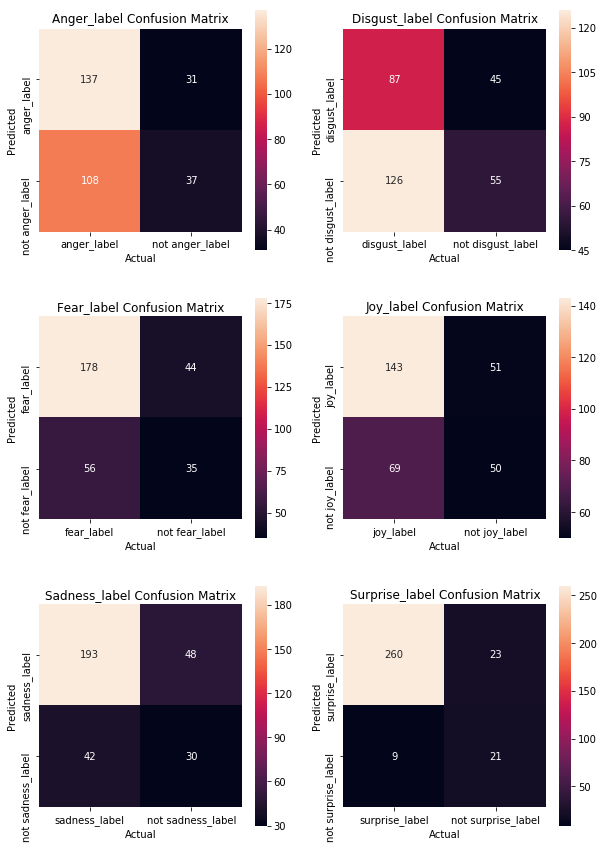

In [15]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [16]:
suite_of_scores(y_test, ovr_test_preds)


jaccard score average: 0.685
hamming loss: 0.25
f1 macro: 0.791


## Classifier Chain

In [17]:
svc = LinearSVC(class_weight='balanced')

perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(svc, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [18]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.703248136315229

In [19]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.5
anger_label precision: 0.8273809523809523
anger_label recall 0.7988505747126436
anger_label f1 0.8128654970760233


disgust_label accuracy: 0.3619402985074627
disgust_label precision: 0.6879432624113475
disgust_label recall 0.6830985915492958
disgust_label f1 0.6855123674911661


fear_label accuracy: 0.6254681647940075
fear_label precision: 0.8608247422680413
fear_label recall 0.784037558685446
fear_label f1 0.8206388206388207


joy_label accuracy: 0.5402298850574713
joy_label precision: 0.7580645161290323
joy_label recall 0.7305699481865285
joy_label f1 0.7440633245382585


sadness_label accuracy: 0.6590909090909091
sadness_label precision: 0.87
sadness_label recall 0.7802690582959642
sadness_label f1 0.8226950354609929


surprise_label accuracy: 0.8885017421602788
surprise_label precision: 0.9172661870503597
surprise_label recall 0.9074733096085409
surprise_label f1 0.9123434704830053




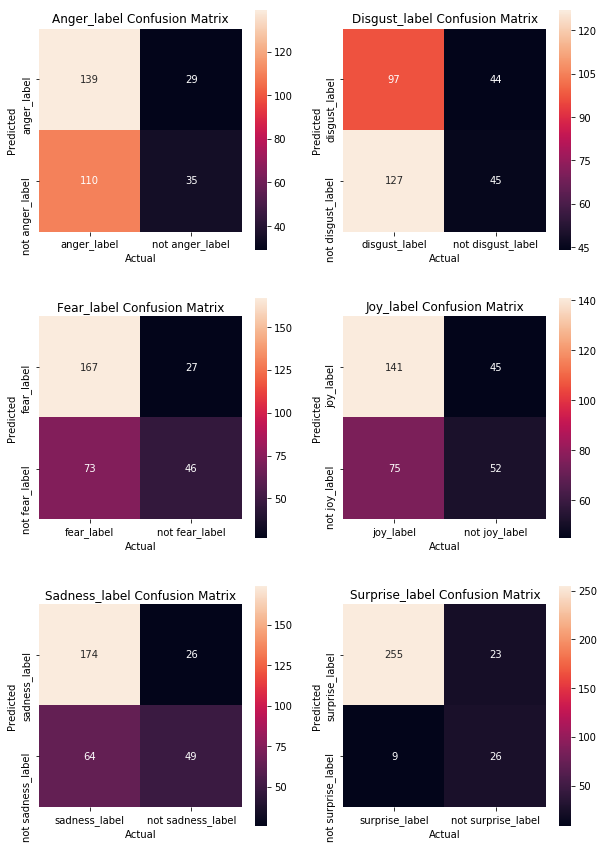

In [20]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [21]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.703
hamming loss: 0.238
f1 macro: 0.8


In [33]:
new = pd.DataFrame({"text":['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace']})
processor = Process_Text_Data()
processor.transform(new)
tf_idf_new = vectorizer.transform(new['text'])

best_chain = chains[results_jaccard.index(max(results_jaccard))]
best_chain.fit(tf_idf_X_train, y_train)
best_chain.predict(tf_idf_new).toarray()

array([[0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

## RNN for Multilabel Classification

In [34]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [35]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df_RNN['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [36]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [37]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [38]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=10)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [39]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 8, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

W0725 11:26:19.778620 4533122496 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 11:26:19.813048 4533122496 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 11:26:19.834089 4533122496 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 11:26:19.858157 4533122496 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 11:26:19.859692 4533122496 deprecation_wrapper

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 2s 3ms/step - loss: 0.6855 - acc: 0.5936 - val_loss: 0.6014 - val_acc: 0.7018
Epoch 2/30
937/937 [==============================] - 0s 462us/step - loss: 0.5265 - acc: 0.7439 - val_loss: 0.5924 - val_acc: 0.7082
Epoch 3/30
937/937 [==============================] - 1s 647us/step - loss: 0.4604 - acc: 0.7958 - val_loss: 0.6032 - val_acc: 0.6805
Epoch 4/30
937/937 [==============================] - 1s 883us/step - loss: 0.4014 - acc: 0.8358 - val_loss: 0.5531 - val_acc: 0.7348
Epoch 5/30
937/937 [==============================] - 0s 475us/step - loss: 0.3496 - acc: 0.8682 - val_loss: 0.5944 - val_acc: 0.7391
Epoch 6/30
937/937 [==============================] - 1s 631us/step - loss: 0.3044 - acc: 0.8919 - val_loss: 0.6020 - val_acc: 0.7279
Epoch 7/30
937/937 [==============================] - 1s 708us/step - loss: 0.2692 - acc: 0.9176 - val_loss: 0.5617 - val_acc: 0.7455
Epoch 8/30
937/937

313/313 [==============================] - 0s 241us/step


[0.5564523549696889, 0.748136326527824]

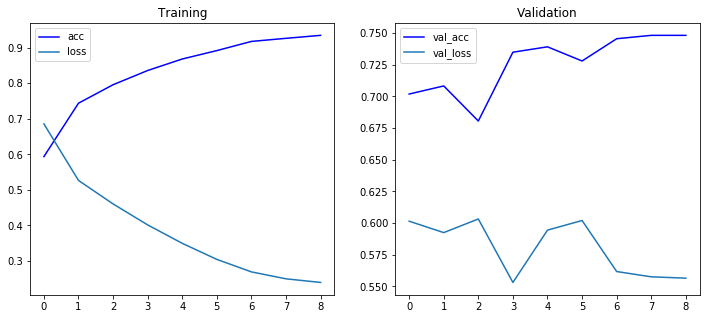

In [40]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [41]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.44483985765124556
anger precision: 0.7961783439490446
anger recall 0.7961783439490446
anger f1 0.7961783439490446


disgust accuracy: 0.30685920577617326
disgust precision: 0.6204379562043796
disgust recall 0.7024793388429752
disgust f1 0.6589147286821705


fear accuracy: 0.5833333333333334
fear precision: 0.7400881057268722
fear recall 0.8704663212435233
fear f1 0.8


joy accuracy: 0.5648854961832062
joy precision: 0.729064039408867
joy recall 0.7437185929648241
joy f1 0.736318407960199


sadness accuracy: 0.6285714285714286
sadness precision: 0.7857142857142857
sadness recall 0.8421052631578947
sadness f1 0.8129330254041571


surprise accuracy: 0.8805460750853242
surprise precision: 0.8958333333333334
surprise recall 0.9280575539568345
surprise f1 0.9116607773851589




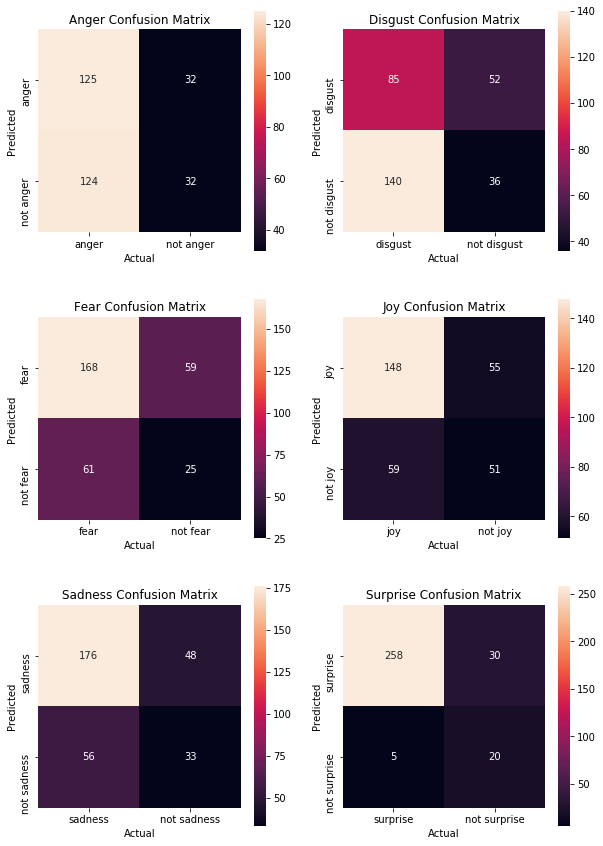

In [42]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [43]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.691
hamming loss: 0.252
f1 macro: 0.786


## Predict something new

In [44]:
new_sequence = tokenizer.texts_to_sequences(['what a great story about happy people having fun !', 'unbelievable news about that sports team that lost tragically'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

model.predict(padded_new)>.5

array([[False, False,  True,  True,  True,  True],
       [ True, False,  True, False,  True,  True]])

In [53]:
# NPR
new_sequence = tokenizer.texts_to_sequences(['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

In [54]:
model.predict(padded_new)>.5

array([[ True,  True,  True, False,  True, False],
       [False,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True],
       [ True, False,  True,  True,  True,  True],
       [False, False, False,  True, False,  True],
       [ True, False,  True,  True,  True,  True],
       [False, False,  True,  True, False,  True],
       [False, False, False,  True, False,  True]])